In [8]:
# This code is written to support the experiments in the book titled:
# "Adaptive Machine Learning Algorithms"
# by
# Chanchal Chatterjee and Vwani P. Roychowdhury
# August 2021
#
# Experiments for Chapter 6 - Accelerated Principal and Minor Eigenvectors of a Matrix Sequence
#
# Author: Chanchal Chatterjee
#
# Speedup of the Adaptive EVD Algorithm 
# Compare Our Gradient Descent, Steepest Descent, Yang's PASTd, Bannour/Sadjadi's RLS, Fu/Dowling's CGET1
#   for non-stationary data

In [9]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf


In [10]:
covX1 = 2 * np.array([ \
[ 0.0910, 0.0380,-0.0530,-0.0050, 0.0100,-0.1360, 0.1550, 0.0300, 0.0020, 0.0320 ], \
[ 0.0380, 0.3730, 0.0180,-0.0280,-0.0110,-0.3670, 0.1540,-0.0570,-0.0310,-0.0650 ], \
[-0.0530, 0.0180, 1.4300, 0.0170, 0.0550,-0.4500,-0.0380,-0.2980,-0.0410,-0.0300 ], \
[-0.0050,-0.0280, 0.0170, 0.0840,-0.0050, 0.0160, 0.0420,-0.0220, 0.0010, 0.0050 ], \
[ 0.0100,-0.0110, 0.0550,-0.0050, 0.0710, 0.0880, 0.0580,-0.0690,-0.0080, 0.0030 ], \
[-0.1360,-0.3670,-0.4500, 0.0160, 0.0880, 5.7200,-0.5440,-0.2480, 0.0050, 0.0950 ], \
[ 0.1550, 0.1540,-0.0380, 0.0420, 0.0580,-0.5440, 2.7500,-0.3430,-0.0110,-0.1200 ], \
[ 0.0300,-0.0570,-0.2980,-0.0220,-0.0690,-0.2480,-0.3430, 1.4500, 0.0780, 0.0280 ], \
[ 0.0020,-0.0310,-0.0410, 0.0010,-0.0080, 0.0050,-0.0110, 0.0780, 0.0670, 0.0150 ], \
[ 0.0320,-0.0650,-0.0300, 0.0050, 0.0030, 0.0950,-0.1200, 0.0280, 0.0150, 0.3410 ]])
covX2 = 4*np.array([ \
[ 0.0900, 0.0010,-0.0080,-0.1910,-0.0070, 0.0410,-0.0300,-0.0580, 0.0220, 0.0320 ], \
[ 0.0010, 0.0920,-0.0110, 0.0080,-0.0140,-0.0020, 0.0120,-0.0100,-0.0210,-0.0020 ], \
[-0.0080,-0.0110, 0.0820, 0.0820, 0.0140,-0.0200,-0.0580, 0.1050, 0.0040, 0.0230 ], \
[-0.1910, 0.0080, 0.0820, 5.6800,-0.0960,-0.0150, 0.6460, 0.2190,-0.2380, 0.2180 ], \
[-0.0070,-0.0140, 0.0140,-0.0960, 0.0760,-0.0350,-0.0400,-0.0230, 0.0270,-0.0140 ], \
[ 0.0410,-0.0020,-0.0200,-0.0150,-0.0350, 0.4580, 0.1380,-0.2510, 0.0120, 0.0390 ], \
[-0.0300, 0.0120,-0.0580, 0.6460,-0.0400, 0.1380, 1.8200,-0.1830,-0.0020, 0.1170 ], \
[-0.0580,-0.0100, 0.1050, 0.2190,-0.0230,-0.2510,-0.1830, 4.0700,-0.4640, 0.1470 ], \
[ 0.0220,-0.0210, 0.0040,-0.2380, 0.0270, 0.0120,-0.0020,-0.4640, 0.2630, 0.0540 ], \
[ 0.0320,-0.0020, 0.0230, 0.2180,-0.0140, 0.0390, 0.1170, 0.1470, 0.0540, 0.3870 ]])

covX2/4

array([[ 9.00e-02,  1.00e-03, -8.00e-03, -1.91e-01, -7.00e-03,  4.10e-02,
        -3.00e-02, -5.80e-02,  2.20e-02,  3.20e-02],
       [ 1.00e-03,  9.20e-02, -1.10e-02,  8.00e-03, -1.40e-02, -2.00e-03,
         1.20e-02, -1.00e-02, -2.10e-02, -2.00e-03],
       [-8.00e-03, -1.10e-02,  8.20e-02,  8.20e-02,  1.40e-02, -2.00e-02,
        -5.80e-02,  1.05e-01,  4.00e-03,  2.30e-02],
       [-1.91e-01,  8.00e-03,  8.20e-02,  5.68e+00, -9.60e-02, -1.50e-02,
         6.46e-01,  2.19e-01, -2.38e-01,  2.18e-01],
       [-7.00e-03, -1.40e-02,  1.40e-02, -9.60e-02,  7.60e-02, -3.50e-02,
        -4.00e-02, -2.30e-02,  2.70e-02, -1.40e-02],
       [ 4.10e-02, -2.00e-03, -2.00e-02, -1.50e-02, -3.50e-02,  4.58e-01,
         1.38e-01, -2.51e-01,  1.20e-02,  3.90e-02],
       [-3.00e-02,  1.20e-02, -5.80e-02,  6.46e-01, -4.00e-02,  1.38e-01,
         1.82e+00, -1.83e-01, -2.00e-03,  1.17e-01],
       [-5.80e-02, -1.00e-02,  1.05e-01,  2.19e-01, -2.30e-02, -2.51e-01,
        -1.83e-01,  4.07e+00, -4.64e-

In [11]:
from scipy.linalg import eigh

# Number of samples N and dimension D
nSamples1 = 500
nSamples2 = 1000
nSamples = nSamples1 + nSamples2
nDim = 10
nEA = 4
nEpochs = 1

eigvals1, eigvecs1 = eigh(covX1)
print("eigvals1 =\n", eigvals1[::-1])
V1 = np.fliplr(eigvecs1)
D1  = np.diag(np.sqrt(eigvals1[::-1]))

eigvals2, eigvecs2 = eigh(covX2)
print("eigvals2 =\n", eigvals2[::-1])
V2 = np.fliplr(eigvecs2)
D2  = np.diag(np.sqrt(eigvals2[::-1]))

np.random.seed(1)
R1 = np.random.normal(0, 1, (nDim, nSamples1))
R2 = np.random.normal(0, 1, (nDim, nSamples2))
X1 = V1 @ D1 @ R1
X2 = V2 @ D2 @ R2
XX = np.concatenate((X1,X2),axis=1)


eigvals1 =
 [11.79962474  5.56438753  3.41750617  2.0588796   0.78726809  0.5877646
  0.17426915  0.14232806  0.12129678  0.10067527]
eigvals2 =
 [23.36623305 16.56981781  6.86112929  1.83785592  1.54517663  0.70102746
  0.38511074  0.31010599  0.26774266  0.22780046]


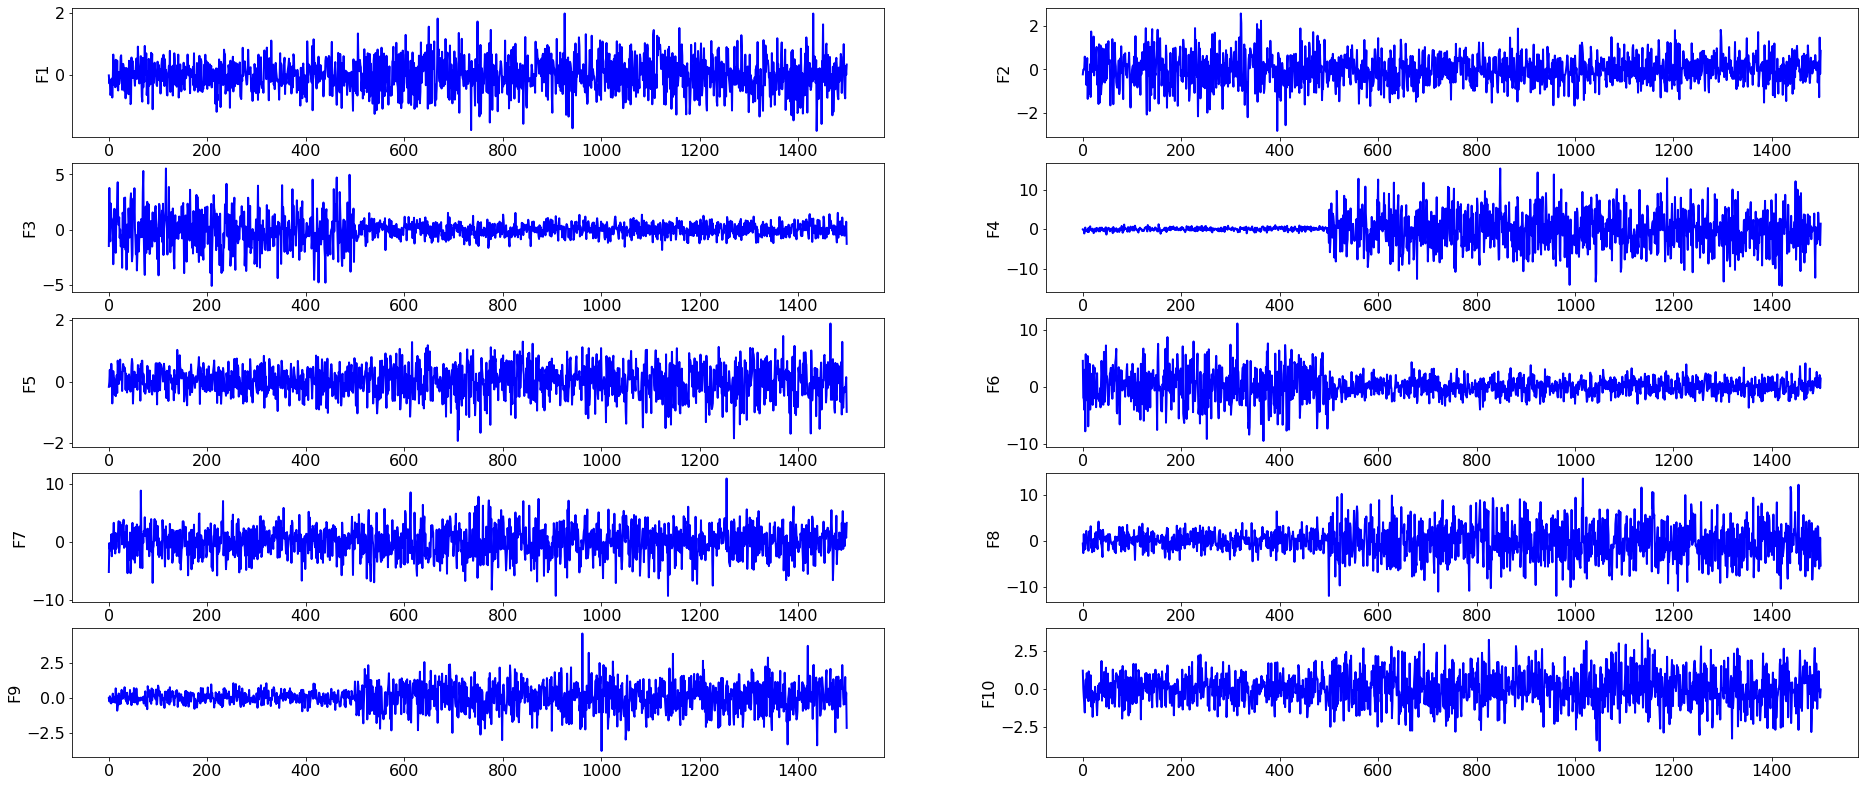

In [12]:
# Plot the data
dataset = pd.DataFrame(XX.T, columns=['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10'])
plt.figure(figsize=(32, 48))
plt.rcParams.update({'font.size': 16})
cols = dataset.columns
for i in range(dataset.shape[1]):
    plt.subplot(17, 2, i+1)
    plt.ylabel(cols[i])
    plt.plot(dataset[cols[i]], lw=2, color='b')
plt.show()

In [13]:
# Square root of the correlation matrix
from scipy.linalg import eigh

# Compute Correlation matrix and eigen vectors of the generated data
corX1 = (X1 @ X1.T) / nSamples1
corX2 = (X2 @ X2.T) / nSamples2

# Eigenvalues and eigenvectors of corX1
eigvals1, eigvecs1 = eigh(corX1)
print("eigvals1 =\n", eigvals1[::-1])
EstV1 = np.fliplr(eigvecs1)
EstD1  = np.diag(eigvals1[::-1])

# Eigenvalues and eigenvectors of corX1
eigvals2, eigvecs2 = eigh(corX2)
print("eigvals2 =\n", eigvals2[::-1])
EstV2 = np.fliplr(eigvecs2)
EstD2  = np.diag(eigvals2[::-1])



eigvals1 =
 [11.57496378  5.28823534  3.5922915   2.19877606  0.78147791  0.51573056
  0.18216373  0.1398918   0.13034506  0.09593603]
eigvals2 =
 [23.07766682 16.07151083  6.8474717   1.98537022  1.38479098  0.68604875
  0.39273715  0.2998105   0.27070265  0.23266132]


In [22]:
# Initialize all variables for adaptive algorithm
from numpy import linalg as la

Weight = 0.995
A  = np.zeros(shape=(nDim,nDim)) # stores adaptive correlation matrix
W1 = 0.1 * np.ones(shape=(nDim,nEA)) # weight vectors of all algorithms
I  = np.identity(nDim)

# Initial Values for PASTd
W2 = 0.1 * np.ones(shape=(nDim,nEA)) # weight vectors of all algorithms
d  = 0.2 * np.ones(nEA)
y  = np.zeros(nEA)
E  = np.zeros(shape=(nDim,nEA))
XX  = np.zeros(shape=(nDim,nEA+1))
beta = Weight

# Initial Values of RLS - Bannour/Sadjadi
W3 = 0.1 * np.ones(shape=(nDim,nEA)) # weight vectors of all algorithms
h  = np.zeros(nEA)
K  = np.zeros(nEA)
P  = np.ones(nEA)
dd = np.zeros(nDim)

# Initial Values of CGET1
W4 = 0.1 * np.ones(shape=(nDim,nEA)) # weight vectors of all algorithms
LL = np.zeros(nEA)
qq = np.zeros(nEA)
Residue = np.zeros(shape=(nDim,nEA))
PP = np.zeros(shape=(nDim,nEA))
XX2 = np.zeros(shape=(nDim,nEA+1))
for i in range(nEA):
    x = X1[:,0].reshape(nDim,1)
    A1 = x @  x.T
    LL[i] = W4[:,i].T @ A1 @ W4[:,i]
    Residue[:,i] = (LL[i] * W4[:,i] - A1 @ W4[:,i]).T
    PP[:,i] = Residue[:,i]/la.norm(Residue[:,i])


In [23]:
# Initialize all variables for adaptive algorithm
from numpy import linalg as la

A  = np.zeros(shape=(nDim,nDim)) # stores adaptive correlation matrix
W1 = 0.1 * np.ones(shape=(nDim,nEA)) # weight vectors of all algorithms
W2 = W1
c = [2-0.3*k for k in range(nEA)]
C = np.diag(c)
I  = np.identity(nDim)

cos_t1 = np.zeros(shape=(nEA, nSamples*nEpochs)) # cosine error
cos_t2 = np.zeros(shape=(nEA, nSamples*nEpochs)) # cosine error
cos_t3 = np.zeros(shape=(nEA, nSamples*nEpochs)) # cosine error
cos_t4 = np.zeros(shape=(nEA, nSamples*nEpochs)) # cosine error

for epoch in range(nEpochs):
    for iter in range(nSamples):
        cnt = nSamples*epoch + iter

        if (iter < nSamples1):
            x = X1[:,iter]
        else:
            x = X2[:,iter-nSamples1]
        x = x.reshape(nDim,1)
        A = Weight * A + (1.0/(1 + cnt))*((np.dot(x, x.T)) - Weight * A)
        
        # Steepest Descent
        G = -2 * A @ W1 + A @ W1 @ np.triu(W1.T @ W1) + W1 @ np.triu(W1.T @ A @ W1)
        for i in range(nEA):
            M = np.zeros(shape=(nDim,nDim))
            for k in range(i):
                w1 = W1[:,k].reshape(nDim,1)
                M = M + (A @ (w1 @ w1.T) + (w1 @ w1.T) @ A)
         
            wi = W1[:,i].reshape(nDim,1)
            F = - 2*A + 2*A @ (wi @ wi.T) + 2 * (wi @ wi.T) @ A + A * (wi.T @ wi) + \
                    (wi.T @ A @ wi) * I  +  M
            gi = G[:,i].reshape(nDim,1)
            a0 = np.asscalar(gi.T @ gi)
            a1 = np.asscalar(- gi.T @ F @ gi)
            a2 = np.asscalar(3 * ((wi.T @ A @ gi) @ (gi.T @ gi) + (gi.T @ A @ gi)*(wi.T @ gi)))
            a3 = np.asscalar(- 2 * (gi.T @ A @ gi) @ (gi.T @ gi))
            c  = np.array([a3, a2, a1, a0])
            rts = np.roots(c)
         
            rs = np.zeros(3)
            r  = np.zeros(3)
            J  = np.zeros(3)

            cnt1 = 0
            for k in range(3):
                if np.isreal(rts[k]):
                    re = np.real(rts[k])
                    rs[cnt1] = re
                    r = W1[:,i] - re * G[:,i]
                    J[cnt1] = np.asscalar(-2*(r.T @ A @ r) + (r.T @ A @ r) * (r.T @ r) + (r.T @ M @ r))
                    cnt1 = cnt1 + 1
            yy = min(J)
            iyy = np.argmin(J)

            alpha = rs[iyy]
         
            W1[:,i] = (W1[:,i] - alpha * G[:,i]).T

            # PASTd - Yang
            if (iter < nSamples1):
                x = X1[:,iter]
            else:
                x = X2[:,iter-nSamples1]
            XX[:,0] = x.T
            for i in range(nEA):
                y[i] = W2[:,i].T @ XX[:,i]
                d[i] = beta * d[i] + y[i]*y[i]
                E[:,i] = (XX[:,i] - W2[:,i]*y[i]).T
                W2[:,i] = (W2[:,i] + E[:,i]*(y[i]/d[i])).T
                XX[:,i+1] = (XX[:,i] - W2[:,i]*y[i]).T
 
            # RLS - Bannour/Sadjadi
            for i in range(nEA):
                h[i] = W3[:,i].T @ x
                K[i] = (P[i]*h[i]) / (1 + h[i] * h[i] * P[i])
                dd = np.zeros(nDim)
                for j in range(i):
                    dd = dd + h[j]*W3[:,j]
                W3[:,i] = (W3[:,i] + K[i]*(x - dd - h[i]*W3[:,i])).T
                P[i] = (1 - K[i] * h[i]) * P[i]
                
            # CGET1 - Fu/Dowling
            for i in range(nEA):
                if ((PP[:,i].T @ A @ PP[:,i]) == 0):
                    continue
                qq[i] = (Residue[:,i].T @ A @ PP[:,i]) / (PP[:,i].T @ A @ PP[:,i])
                PP[:,i] = (Residue[:,i] - qq[i]*PP[:,i]).T
                DD = np.zeros(shape=(nDim,nDim))
                for j in range(i):
                    w4j = W4[:,j].reshape(nDim,1)
                    DD = DD + w4j @ w4j.T
                BB = I - DD
                AA = BB.T @ A @ BB
                lx = W4[:,i].T @ AA @ W4[:,i]
                ax = W4[:,i].T @ AA @ PP[:,i]
                bx = PP[:,i].T @ AA @ PP[:,i]
                ex = W4[:,i].T @ BB @ W4[:,i]
                cx = W4[:,i].T @ BB @ PP[:,i]
                dx = PP[:,i].T @ BB @ PP[:,i]
                fx = bx*ex - lx*dx
                gx = ax*ex - lx*cx
                hx = bx*cx - ax*dx
                if (hx == 0):
                    continue
                tx = (-fx - np.sqrt(fx**2 - 4*hx*gx))/(2*hx)
                XX2[:,i] = (W4[:,i] + tx*PP[:,i]).T
                W4[:,i] = ((BB @ XX2[:,i])/np.sqrt(XX2[:,i].T @ BB @ XX2[:,i])).T
                LL[i] = W4[:,i].T @ A @ W4[:,i]
                Residue[:,i] = (LL[i] * W4[:,i] - A @ W4[:,i]).T
 
        for i in range(nEA):
            u1 = (W1[:,i]/la.norm(W1[:,i])).reshape(nDim,1)
            u2 = (W2[:,i]/la.norm(W2[:,i])).reshape(nDim,1)
            u3 = (W3[:,i]/la.norm(W3[:,i])).reshape(nDim,1)
            u4 = (W4[:,i]/la.norm(W4[:,i])).reshape(nDim,1)
            if (iter < nSamples1):
                vi = EstV1[:,i].reshape(nDim,1)
            else:
                vi = EstV2[:,i].reshape(nDim,1)
            cos_t1[i,cnt] = abs(u1.T @ vi)
            cos_t2[i,cnt] = abs(u2.T @ vi)
            cos_t3[i,cnt] = abs(u3.T @ vi)
            cos_t4[i,cnt] = abs(u4.T @ vi)


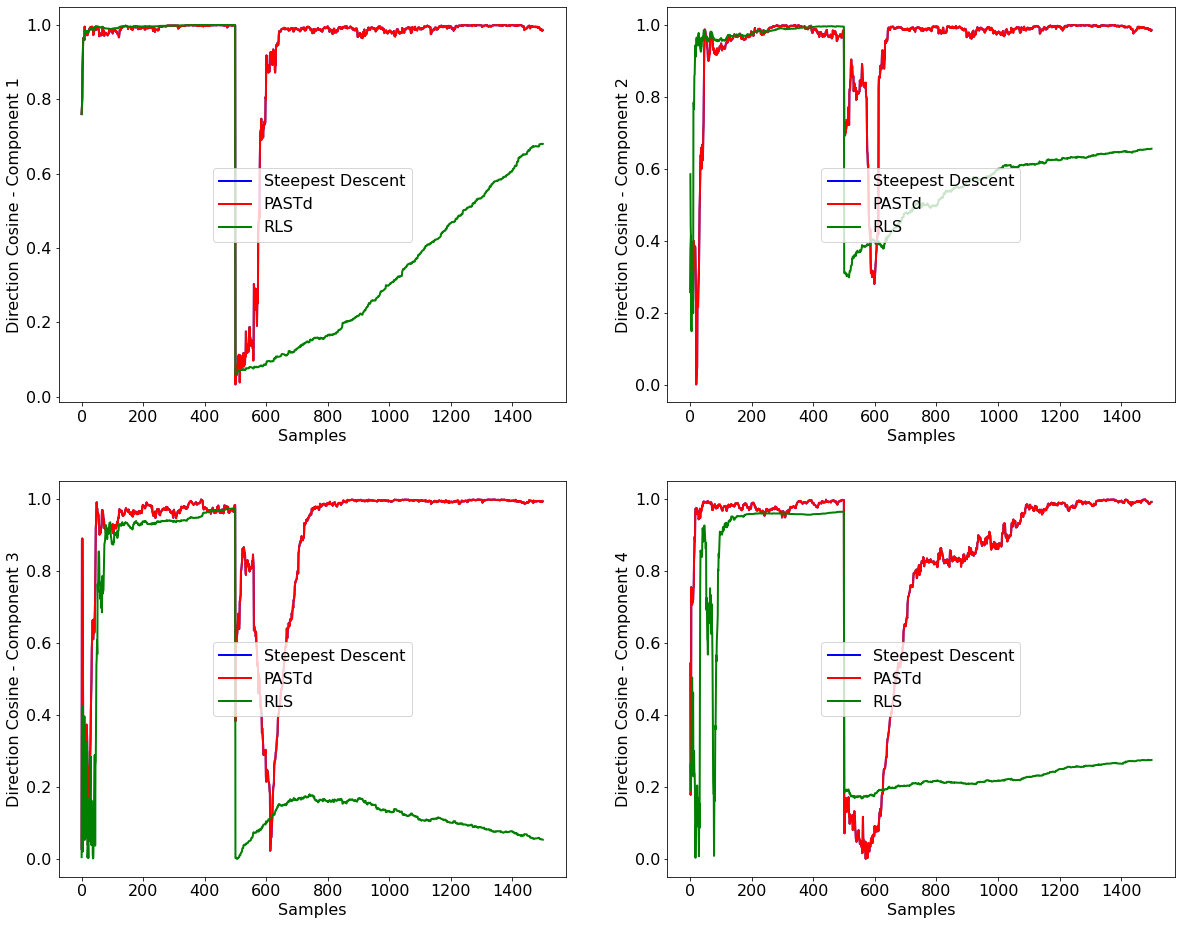

In [24]:
plt.figure(figsize=(20, 16))
plt.rcParams.update({'font.size': 16})

plt.subplot(2, 2, 1)
plt.plot(cos_t1[0,:], lw=2, color='b', label='Steepest Descent')
plt.plot(cos_t2[0,:], lw=2, color='r', label='PASTd')
plt.plot(cos_t3[0,:], lw=2, color='g', label='RLS')
#plt.plot(cos_t4[0,:], lw=2, color='k', label='CGET1')
plt.ylabel('Direction Cosine - Component 1')
plt.xlabel('Samples')
plt.legend(loc="center")

plt.subplot(2, 2, 2)
plt.plot(cos_t1[1,:], lw=2, color='b', label='Steepest Descent')
plt.plot(cos_t2[1,:], lw=2, color='r', label='PASTd')
plt.plot(cos_t3[1,:], lw=2, color='g', label='RLS')
#plt.plot(cos_t4[1,:], lw=2, color='k', label='CGET1')
plt.ylabel('Direction Cosine - Component 2')
plt.xlabel('Samples')
plt.legend(loc="center")

plt.subplot(2, 2, 3)
plt.plot(cos_t1[2,:], lw=2, color='b', label='Steepest Descent')
plt.plot(cos_t2[2,:], lw=2, color='r', label='PASTd')
plt.plot(cos_t3[2,:], lw=2, color='g', label='RLS')
#plt.plot(cos_t4[2,:], lw=2, color='k', label='CGET1')
plt.ylabel('Direction Cosine - Component 3')
plt.xlabel('Samples')
plt.legend(loc="center")

plt.subplot(2, 2, 4)
plt.plot(cos_t1[3,:], lw=2, color='b', label='Steepest Descent')
plt.plot(cos_t2[3,:], lw=2, color='r', label='PASTd')
plt.plot(cos_t3[3,:], lw=2, color='g', label='RLS')
#plt.plot(cos_t4[3,:], lw=2, color='k', label='CGET1')
plt.ylabel('Direction Cosine - Component 4')
plt.xlabel('Samples')
plt.legend(loc="center")

plt.show()